In [57]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1


%matplotlib inline

In [12]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_70000.ckpt',),'res101': ('res101_faster_rcnn_iter_110000.ckpt',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

In [14]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    
def demo(sess, net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(sess, net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time, boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Tensorflow Faster R-CNN demo')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16 res101]',
                        choices=NETS.keys(), default='res101')
    parser.add_argument('--dataset', dest='dataset', help='Trained dataset [pascal_voc pascal_voc_0712]',
                        choices=DATASETS.keys(), default='pascal_voc_0712')
    args = parser.parse_args()

    return args

# Load Net

In [55]:
cfg.TEST.HAS_RPN = True

# model path
demonet = "res101"
dataset = 'pascal_voc_0712'
tfmodel = os.path.join('output', demonet, DATASETS[dataset][0], 'default',
                          NETS[demonet][0])
if not os.path.isfile("../"+tfmodel + '.meta'):
    raise IOError(('{:s} not found.\nDid you download the proper networks from '
                   'our server and place them properly?').format(tfmodel + '.meta'))

# set config
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth=True

# init session
sess = tf.Session(config=tfconfig)
# load network
if demonet == 'vgg16':
    net = vgg16()
elif demonet == 'res101':
    net = resnetv1(num_layers=101)
else:
    raise NotImplementedError

net.create_architecture("TEST", 21,
                      tag='default', anchor_scales=[8, 16, 32])
saver = tf.train.Saver()
saver.restore(sess, "../"+tfmodel)

INFO:tensorflow:Restoring parameters from ../output/res101/voc_2007_trainval+voc_2012_trainval/default/res101_faster_rcnn_iter_110000.ckpt


# Demo

im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
                '001763.jpg', '004545.jpg']


Detection took 0.126s for 300 object proposals


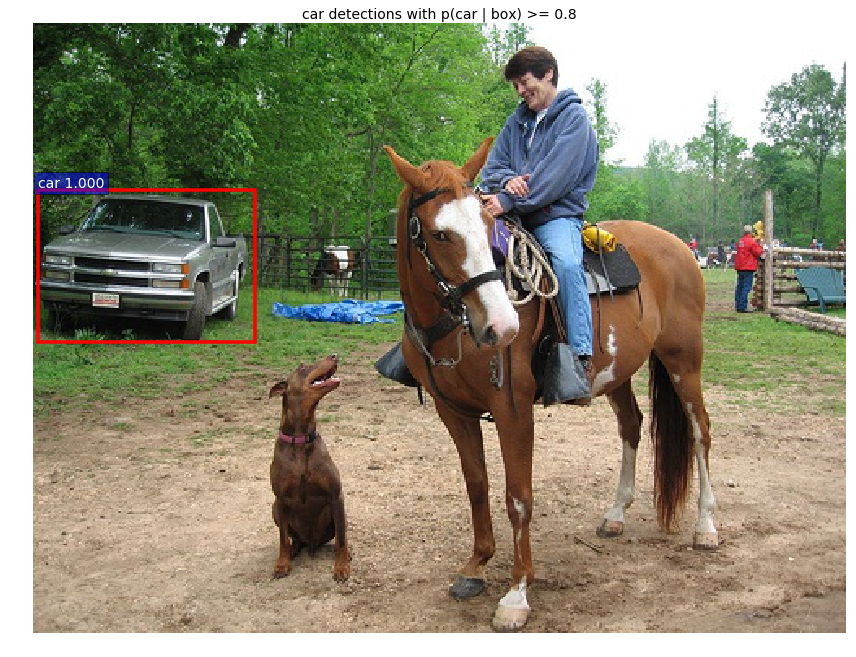

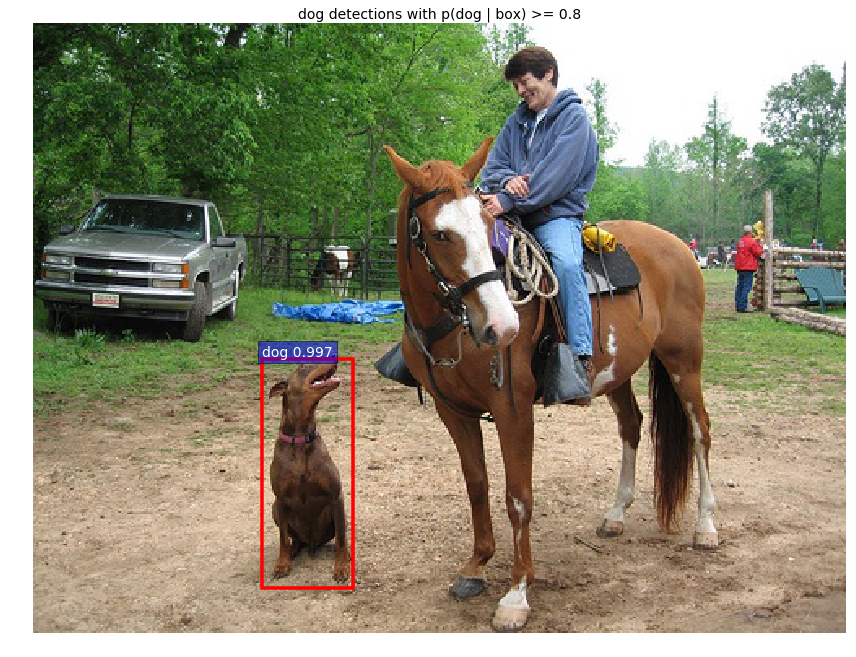

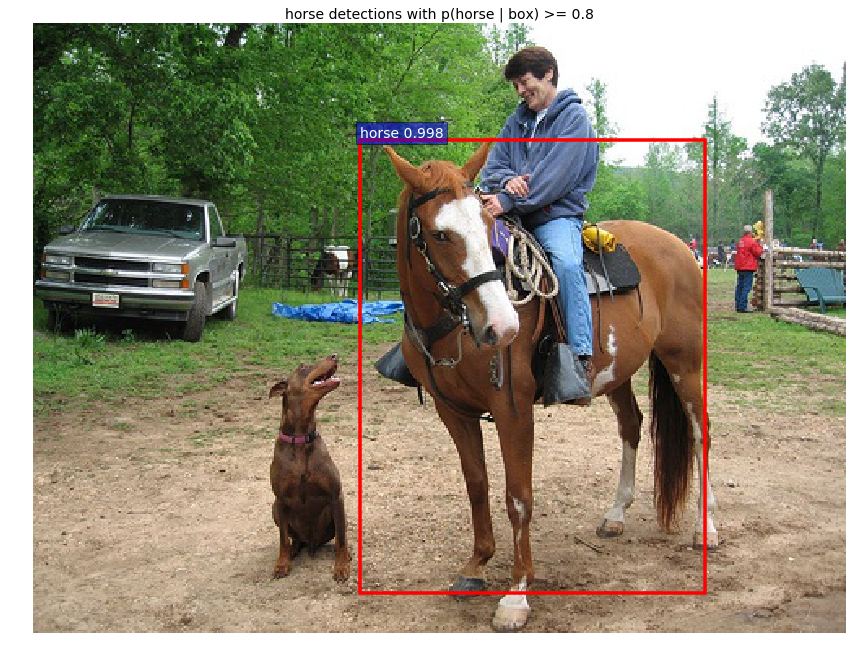

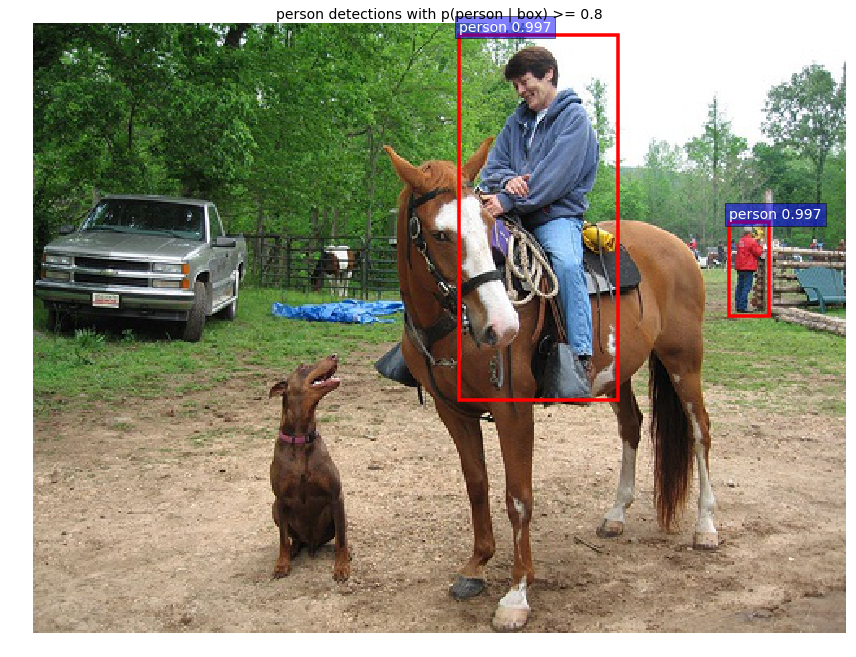

In [62]:
demo(sess, net, '004545.jpg')

# Inspect im_dect